# Procesamiento de datos de Péndulos Acoplados
## Encontrar ceros, alturas y anchos

La medición de péndulos acoplados implica la lectura del voltímetro doble.   
Allí tenemos la señal del imán que pasa sobre la bobina. La información que podemos sacar de esas mediciones es:
* la altura de los picos,
* el ancho temporal entre picos,
* el tiempo en que la señal cruza el cero.

Los péndulos acoplados tienen un montón de física, pero antes tenemos que tener muchos y buenos datos. 

El objetivo de este apunte es apenas obtener los tiempos de crice por cero, la altura de los picos y el ancho.

Cambiando el archivo de entrada, se va procesando en cada celda.   
Al principio de las celdas, entre líneas de `##################` están los parámetros de entrada.



In [1]:
### Importaciones de rigor

%pylab inline
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

Populating the interactive namespace from numpy and matplotlib


## 1. Importo datos

In [2]:
############################
pat   = './Longitudes/'
fil   = 'Longitud4.txt'
############################
pathFile = pat + fil

def loadV2(filenam):
    '''loadV2(filenam) carga datos del voltímetro doble
    Corrige los tiempos para que comience en cero
    Resta la componente DC del voltaje
    Multiplica por 1000, para que esté en mV
    '''
    try:
        data=loadtxt(filenam,skiprows=1)
        x,y1,y2=zip(*data)
        x =array(x)-x[0]                # corrijo el origen de x
        y1=(array(y1)-mean(y1))*1000.   # promedio y1 a 0
        y2=(array(y2)-mean(y2))*1000.   # promedio y2 a 0
        return x,y1,y2
    except:
        ### Los archivos originales tienen coma en lugar de punto
        ### Hay que reemplazarlas para que no falle 'loadtxt'
        with open(filenam,'r') as fi:
            data=fi.readlines()
    
        with open(filenam,'w') as fo:
            for item in data:
                dataP = item.replace(',','.')
                fo.write(dataP)
                
        return loadV2(filenam)

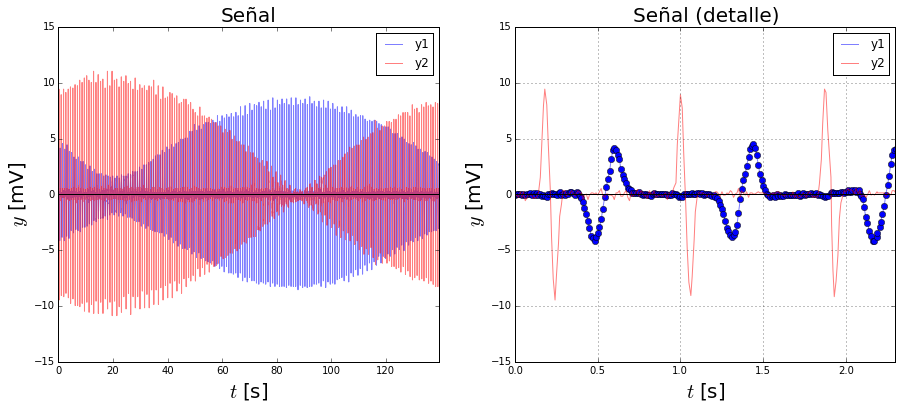

In [3]:
### Cargo y observo los datos

### cargo datos
x,y1,y2=loadV2(pathFile)

### Gráfico
figure(figsize=(15,6))
subplot(121)
title(u'Señal', fontsize=20)
plot(x,y1,'b-',alpha=.5, label='y1')
plot(x,y2,'r-',alpha=.5, label='y2')

ylabel(r'$y$ [mV]', fontsize=20)
xlabel(r'$t$ [s]',    fontsize=20)
xlim(0,x[-1])
axhline(0,color='k')
legend()

subplot(122)
title(u'Señal (detalle)', fontsize=20)
plot(x,y1,'b-',label='y1',alpha=0.5)
plot(x,y1,'bo')
plot(x,y2,'r-',label='y2',alpha=0.5)
ylabel(r'$y$ [mV]', fontsize=20)
xlabel(r'$t$ [s]',    fontsize=20)
xlim(0,2.3)
axhline(0,color='k')
legend()
grid()
show()

## 2. Ubicar los máximos y mínimos significativos

Los picos están donde se suceden un máximo y un mínimo. 

Esto suena fácil, pero existe el ruido. Necesito caracterizarlo para establecer umbrales.

Para eso, hacemos una rutina de suavizado, que promedia los vecinos. Se aplica varias veces.  
La idea es atenuar el ruido sin arruinar mucho los picos. El parámetro de ajuste es el tamaño del kernel. 

La magnitud de el ruido puede estimarse restando la señal original a la señal suavizada.  
Elegimos como umbral: 2 veces la desviación estándar de esa resta.

Luego busco los extremos locales que están por encima del umbral.

In [4]:
##############################################################
### Parámetros de sintonía
kernelSize       = 3  # tamaño del kernel de suavizado (impar)
smoothTimes      = 3  # veces que se plica el suavizado
extremeExtension = 5  # extensión en la que busco un extremo
##############################################################

#### Filtrado de la señal
#### Máximos y mínimos locales

from scipy.signal import argrelmin,argrelmax

def smooth(signal, kernel_size,times=1):
    '''smooth(signal, kernel_size,times=1)  suavizado de una señal
    kernel_size: es un entero que indica cuántos datos promedio
    times:       es el número de veces que se plica el suavizado
    En cada paso se aplica dos veces: uno al derecho y otro al revés
    '''
    kernel = numpy.ones(int(kernel_size))/float(kernel_size)
    ida = convolve(signal, kernel, 'same')
    vuelta = convolve(ida[::-1], kernel, 'same')[::-1]
    
    if times==1:
        return vuelta
    else:
        return smooth(vuelta,kernel_size,int(times-1))

def iextreme(signal,order=extremeExtension):
    '''iextreme(signal,order=extremeExtension)
    devuelve una lista de índices en las que la señal tiene un extremo. 
    '''
    imax = argrelmax(signal,order=order)[0]
    imin = argrelmin(signal,order=order)[0]
    iext = sorted(concatenate((imax,imin)))
    return iext

### Señal suavizada
y1s = smooth(y1,kernelSize,times=smoothTimes)    
y2s = smooth(y2,kernelSize,times=smoothTimes)

### Extremos locales
i1ext = iextreme(y1s)
i2ext = iextreme(y2s)

y1ext = y1s[i1ext]
y2ext = y2s[i2ext]
x1ext = x[i1ext]
x2ext = x[i2ext]

### Proceso los umbrales
umbral1 = 2.5*std(y1-y1s)
umbral2 = 2.5*std(y2-y2s)

i1M = where(abs(y1ext)>umbral1)
x1M=x1ext[i1M]
y1M=y1ext[i1M]

i2M = where(abs(y2ext)>umbral2)
x2M=x2ext[i2M]
y2M=y2ext[i2M]

print ('umbrales:',umbral1,umbral2)

umbrales: 1.18421763865 1.78704817973


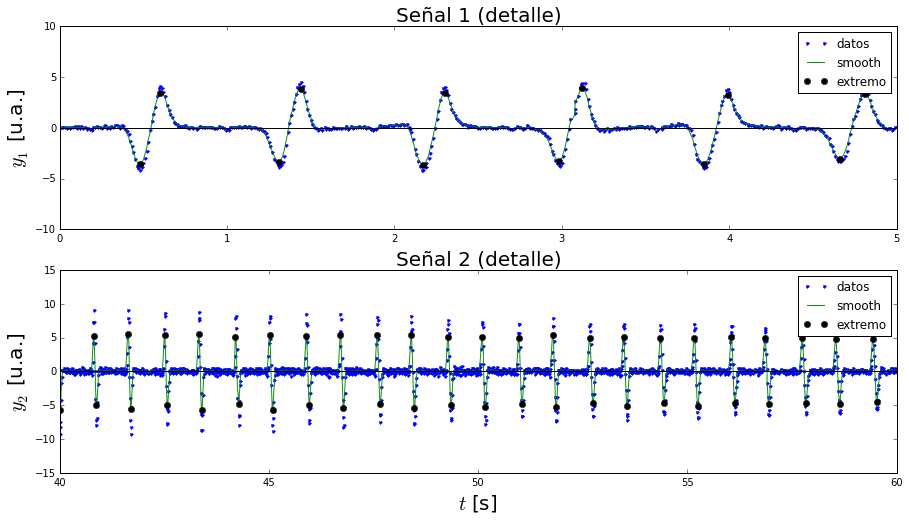

In [5]:
## Figuras de chequeo
## comentando y cambiando los límites, puedo observar diferentes detalles

figure(figsize=(15,8))
xmax=5

subplot(211)
title(u'Señal 1 (detalle)', fontsize=20)
plot(x,y1,'b.',label='datos')
plot(x,y1s,'g-',label='smooth',alpha=0.9)
plot(x1M,y1M,'ko',label='extremo',alpha=1)

ylabel(r'$y_1$ [u.a.]', fontsize=20)
#xlabel(r'$t$ [s]',    fontsize=20)
xlim(0,xmax)
yl=1.
#ylim(-yl,yl)
axhline(0,color='k')
legend()

subplot(212)
title(u'Señal 2 (detalle)', fontsize=20)
plot(x,y2,'b.',label='datos')
plot(x,y2s,'g-',label='smooth',alpha=0.9)
plot(x2M,y2M,'ko',label='extremo',alpha=1)

ylabel(r'$y_2$ [u.a.]', fontsize=20)
xlabel(r'$t$ [s]',    fontsize=20)
#xlim(0,xmax)
xlim(40,60)
axhline(0,color='k')
legend()
show()

## 3. Ubicar los cruces por cero

Algunos picos medidos cruzan por cero con rampa de pendiente positiva y otros con pendiente negativa.   
La idea es ubicar la secuencia de máximos con la pendiente correcta, y que no estén separados más de un período. 

Cuando encuentro los pares de máximo/mínimo, calculo el tiempo entre ambos, la diferencia de alturas entre extremos  y el cruce por cero.

Para calcular el cruce por ceros, ajusto una recta entre los extremos. Anda fenómeno.

304 picos procesados


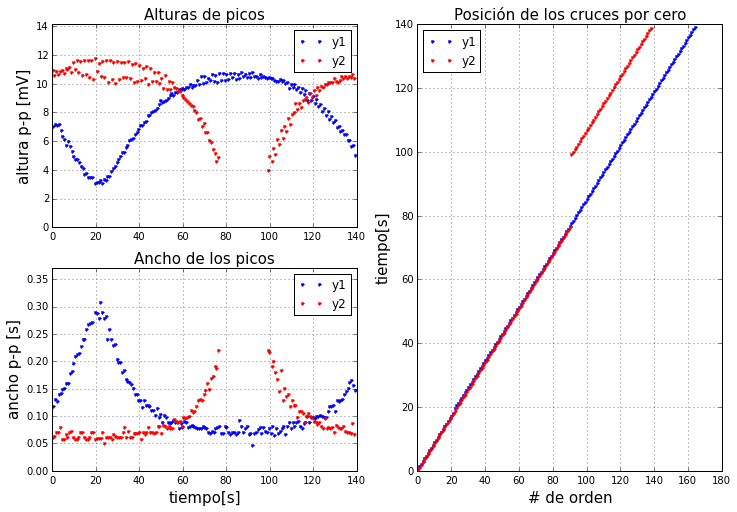

In [6]:
######################################
Ta1 = .5  #período aproximado [s] (un poco menor)
Ta2 = .5
sg1 = +1
sg2 = -1
######################################

def cruces(xM,yM,sg,Ta):
    '''cruces(xM,yM,sg,Ta) identifica los pares de datos que pueden ser un cruce
    para que lo sean tienen que verificar que:
    * haya un cambio de signo
    * que tenga la dirección apropiada (+- sg)
    * que estén separdos menos de un período (masomenos)
    '''
    indx = []
    for i in range(len(xM)-1):
        if yM[i]*yM[i+1] >= 0:
            continue
        elif sign(-yM[i]+yM[i+1])!=sg:
            continue
        else:
            ## Lo tengo !
            indx.append(i)
    indx=array(indx)
    dx = xM[indx+1]-xM[indx]
    indx = indx[(dx<Ta)]
    
    return indx
        
def zero_alt (x,y,xM,yM,indx):
    '''zero_alt (x,y,xM,yM,indx)
    habiendo identificado los índices de 
    los pares de extremos que son picos,
    calculo el ancho, alto y cruce por cero
    '''
    dataT=[]
    for i in indx:
        j = (x>xM[i])&(x<xM[i+1])
        xx,yy = x[j] , y[j]
        z = polyfit(xx,yy,1)
        zero = -z[1]/z[0]
        h = abs( yM[i] - yM[i+1] )
        w = abs( xM[i] - xM[i+1] )
        dataT.append([zero,h,w])
        
    return zip(*dataT)

    
indx1 = cruces(x1M,y1M,sg1,Ta1)
indx2 = cruces(x2M,y2M,sg2,Ta2)

Z1,H1,W1 = zero_alt(x,y1,x1M,y1M,indx1)
Z2,H2,W2 = zero_alt(x,y2,x2M,y2M,indx2)

##### Gráfico
figure(figsize=(12,8))

subplot(221)
title('Alturas de picos', fontsize=15)
plot(Z1,H1,'b.',label='y1')
plot(Z2,H2,'r.',label='y2')
ylim(0,max(list(H2)+list(H1))*1.2)
#xlabel('tiempo[s]', fontsize=15)
ylabel('altura p-p [mV]', fontsize=15)
grid()
legend()

subplot(223)
title('Ancho de los picos', fontsize=15)
plot(Z1,W1,'b.',label='y1')
plot(Z2,W2,'r.',label='y2')
ylim(0,max(list(W2)+list(W1))*1.2)
xlabel('tiempo[s]', fontsize=15)
ylabel('ancho p-p [s]', fontsize=15)
grid()
legend()

subplot(122)
title(u'Posición de los cruces por cero', fontsize=15)
plot(Z1,'b.',label='y1')
plot(Z2,'r.',label='y2')
xlabel('# de orden', fontsize=15)
ylabel('tiempo[s]' , fontsize=15)
grid()
legend(loc=2)

print (len(Z1)+len(Z2), 'picos procesados')

## 4. Guardo los datos

Guardo los datos en archivos que agregan `-med` al nombre original.

Guarda en cuatro columnas: 

$$ Z_1,\ H_1,\ W_1,\ \ Z_2,\ H_2,\ W_2 $$

en formato  `csv`  (_comma separated values_).

In [7]:
#############
add = '-med'
#############
filOu = pat + fil.split('.')[0] + add + '.csv'

### Los datos no tienen el mismo largo
imax = max([len(Z1),len(Z2)])
dif  = len(Z1)-len(Z2)

plus1 = []
plus2 = [' '*8]*dif

if dif<0: plus1,plus2 = plus2,plus1
    
### Para guardarlos, los convierto a strings
Z1s = ['{: 8.3f}'.format(item) for item in Z1] + plus1
H1s = ['{: 8.3f}'.format(item) for item in H1] + plus1
W1s = ['{: 8.3f}'.format(item) for item in W1] + plus1

Z2s = ['{: 8.3f}'.format(item) for item in Z2] + plus2
H2s = ['{: 8.3f}'.format(item) for item in H2] + plus2
W2s = ['{: 8.3f}'.format(item) for item in W2] + plus2

### Guardo los datos
with open(filOu,'w') as fo:
    for item in zip(Z1s,H1s,W1s,Z2s,H2s,W2s):
        line = item[0] + ',' + item[1] + ',' + item[2] + ',' + \
               item[3] + ',' + item[4] + ',' + item[5] + '\n'
        fo.write(line)

print (filOu,'----> Escrito.')

./Longitudes/Longitud4-med.csv ----> Escrito.
